In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import zscore


dd = Path().cwd().parent.parent / 'data'

#dd = Path('/workspaces/marketing-data/data')

We will be using [Census Reporter](https://censusreporter.org) to get census data. This urldata comes from the "download" menu on the page for [San Diego COunty, Sex by Age, aggregated to census tracts.](https://censusreporter.org/data/table/?table=B01001&geo_ids=05000US06073,140|05000US06073&primary_geo_id=05000US06073)  

In [2]:
gdf = gpd.read_file(dd / 'acs2022_5yr_B01001_14000US06073011802.geojson')
gdf.head()

,geoid,name,B01001001,"B01001001, Error",B01001002,"B01001002, Error",B01001003,"B01001003, Error",B01001004,"B01001004, Error",...,"B01001045, Error",B01001046,"B01001046, Error",B01001047,"B01001047, Error",B01001048,"B01001048, Error",B01001049,"B01001049, Error",geometry
0,05000US06073,"San Diego County, CA",3289701.0,NaN,1667851.0,NaN,97861.0,NaN,96806.0,2019.0,...,1533.0,66546.0,1568.0,47881.0,1225.0,32278.0,1224.0,36766.0,1343.0,"MULTIPOLYGON (((-116.7573 32.56551, -116.76272..."
1,14000US06073000100,"Census Tract 1, San Diego, CA",3027.0,373.0,1466.0,222.0,237.0,119.0,65.0,53.0,...,28.0,147.0,80.0,105.0,55.0,74.0,51.0,45.0,32.0,"MULTIPOLYGON (((-117.1949 32.75278, -117.19471..."
2,14000US06073000201,"Census Tract 2.01, San Diego, CA",2294.0,331.0,1101.0,186.0,16.0,21.0,30.0,36.0,...,39.0,109.0,50.0,85.0,54.0,10.0,16.0,126.0,58.0,"MULTIPOLYGON (((-117.17887 32.75765, -117.1779..."
3,14000US06073000202,"Census Tract 2.02, San Diego, CA",3919.0,369.0,2078.0,258.0,53.0,55.0,58.0,59.0,...,13.0,163.0,133.0,65.0,54.0,40.0,39.0,60.0,45.0,"MULTIPOLYGON (((-117.18404 32.74571, -117.1838..."
4,14000US06073000301,"Census Tract 3.01, San Diego, CA",2340.0,363.0,1304.0,328.0,0.0,13.0,13.0,22.0,...,36.0,64.0,46.0,57.0,48.0,0.0,13.0,0.0,13.0,"MULTIPOLYGON (((-117.16864 32.74897, -117.1684..."


To calculate population density, we will also need the land are for the tracts, which is not in the Census Reporter files, so we get the census geography files, which were downloaded from the [Census TigerLine server. ](https://www.census.gov/cgi-bin/geo/shapefiles/index.php)

In [3]:
ca_tract = gpd.read_file('../../data/tl_2022_06_tract.zip')
ca_tract = ca_tract.rename(columns={'GEOID':'geoid', 'ALAND': 'area'})

# Fix the geoid format to match the Census reporter file
ca_tract.geoid = '14000US'+ca_tract.geoid

# For area calculations, should have the same coordinate system
ca_tract.to_crs(gdf.crs)


# Add in the area
t = gdf.merge(ca_tract[['geoid','area']], on='geoid')

t.head()
#gdf.plot(column='B01001001')
t  = t.to_crs(epsg='32611')  # UTM Zone 11N, which covers california
# Calculate the number of children from 0 to 18. 
t['boys'] =  t.B01001003 + t.B01001004 + t.B01001005 + t.B01001006 + t.B01001007 
t['girls'] = t.B01001027 + t.B01001028 + t.B01001029 + t.B01001030 + t.B01001031
t['child'] = t.boys + t.girls

t['child_density'] = t.child / t.area

t.to_file(dd / "child_density.geojson", driver='GeoJSON')

chld = t[['geoid', 'name','area', 'boys', 'girls', 'child', 'child_density','geometry']].copy()


Text(0.5, 1.0, 'Child Density in San Diego County')

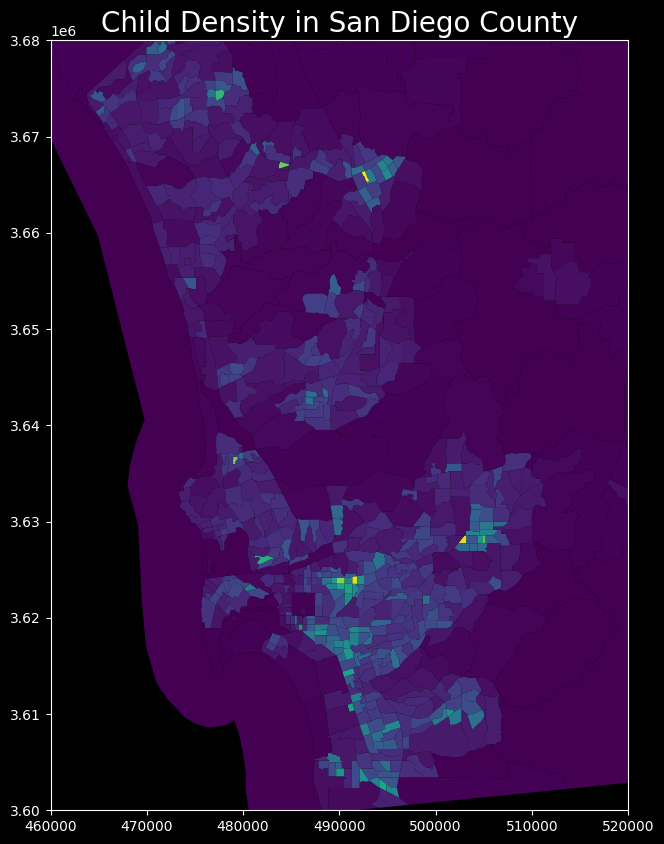

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

plt.style.use('default')
# Set the x and y limits to the specified bounds
ax.set_xlim(460000, 520000)
ax.set_ylim(3600000, 3680000)

t.plot(ax=ax, column='child_density')
ax.set_title('Child Density in San Diego County', fontdict={'fontsize': 20, 'fontweight': 'medium'})


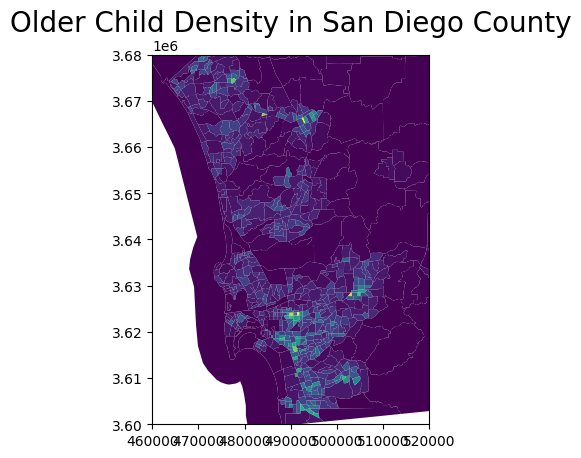

In [5]:
# Older Kids

t  = t.to_crs(epsg='32611')  # UTM Zone 11N, which covers california
# Calculate the number of children from 10 to 17. 
t['boys'] =  t.B01001005 + t.B01001006 
t['girls'] = t.B01001029 + t.B01001030 
t['child'] = t.boys + t.girls

t['child_density'] = t.child / t.area

fig, ax = plt.subplots(1, 1)
ax.set_xlim(460000, 520000)
ax.set_ylim(3600000, 3680000)
t.plot(ax=ax, column='child_density')
ax.set_title('Older Child Density in San Diego County', fontdict={'fontsize': 20, 'fontweight': 'medium'})


t.to_file(dd / "older_child_density.geojson", driver='GeoJSON')

c_den = t


Text(0.5, 1.0, 'Child Density x Money in San Diego County')

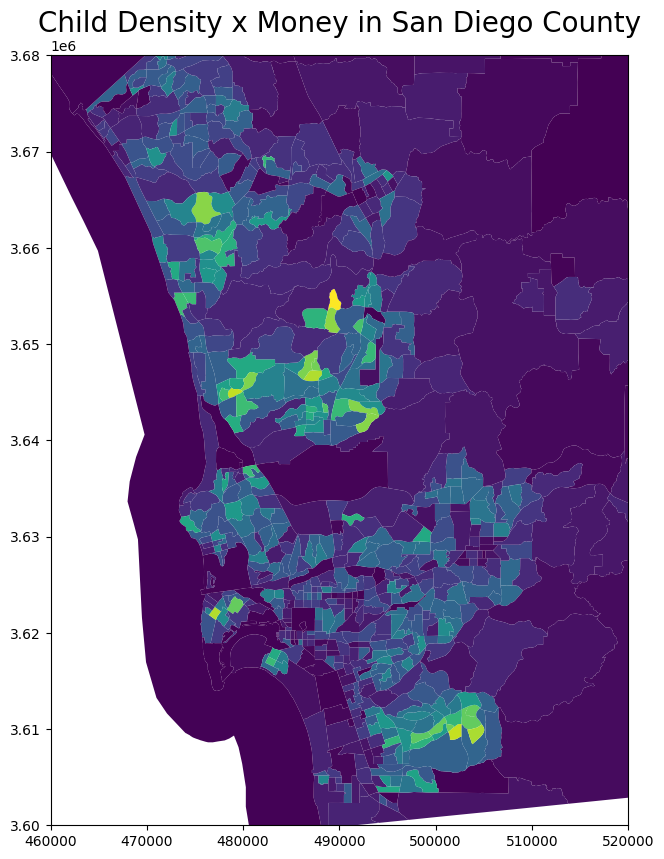

In [6]:
inc = gpd.read_file(dd /'acs2022_5yr_median_household_income.geojson')
inc.head()

t = c_den[['geoid','child_density','geometry']].merge(inc[['geoid','B19013001']]).rename(columns={'B19013001': 'med_income'})
t = t[['geoid', 'child_density', 'med_income', 'geometry']].copy()

t['cd_pct'] = t['child_density'].rank(pct=True)
t['cd_z'] = zscore(t['child_density'])

t['med_income'] = t.med_income.fillna(t.med_income.mean())
t['mi_pct'] = t['med_income'].rank(pct=True)
t['mi_z'] = zscore(t['med_income'])

t['metric'] = t.mi_pct * t.cd_pct

df = t
df.to_file(dd / "cd_mi.geojson", driver='GeoJSON')


fig, ax = plt.subplots(1, 1, figsize=(10,10))


# Set the x and y limits to the specified bounds
ax.set_xlim(460000, 520000)
ax.set_ylim(3600000, 3680000)

df.plot(ax=ax, column='metric')
ax.set_title('Child Density x Money in San Diego County', fontdict={'fontsize': 20, 'fontweight': 'medium'})

In [7]:
from shapely.wkt import loads

territories = gpd.read_file(dd / 'territories-iso.geojson')
locations = gpd.read_file(dd / 'territories-points.geojson')


territories = territories.to_crs(chld.crs)

territories['cid'] = territories['Company'] + '-' + territories.index.astype(str)

t = chld.sjoin(territories[['cid', 'geometry']], how='left', predicate='intersects')

t = t.merge(inc[['geoid', 'B19013001']], on='geoid', how='left')

t.columns
t = t.rename(columns={'B19013001': 'med_income'}).drop(columns=['index_right'])
t['med_income'] = t.med_income.fillna(t.med_income.mean()) 


# Number of competitors in that tract
t['ccount'] = t.groupby('geoid')['cid'].transform('nunique')

t = t[t.ccount > 0]

# CHildren per competitor
t['comp_child']  = t.child / t.ccount

t['over_med'] = t.med_income - t.drop_duplicates(subset=['geoid']).med_income.median()

ter_chld = t


In [8]:
t = ter_chld[ter_chld.over_med > 0]
t.groupby('cid').comp_child.sum().sort_values()


# Group by 'cid' and sum the 'child' column
child_sum =t.groupby('cid').comp_child.sum().sort_values().astype(int)

# Convert the result to a DataFrame for better HTML display
child_sum_df = child_sum.reset_index().rename(columns={'child': 'Total Children'}).sort_values('cid')





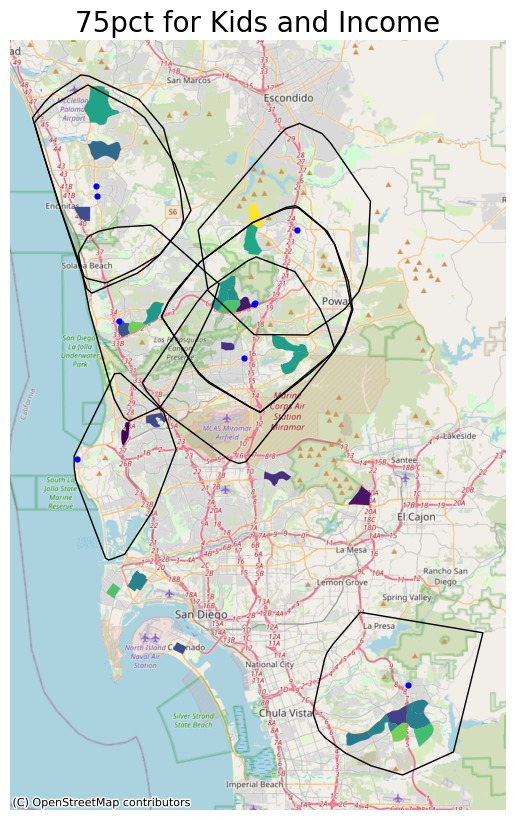

In [9]:
import contextily as ctx

import matplotlib.pyplot as plt

# Child Density for top 20% of income
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Set the x and y limits to the specified bounds
#ax.set_xlim(460000, 520000)
#ax.set_ylim(3600000, 3680000)

t = df[ (df.mi_pct >= .70) & ( df.cd_pct > .70)]

t.to_file(dd / "cd_mi_70.geojson", driver='GeoJSON')

t.to_crs(epsg=3857).plot(ax=ax, column='metric')
ax.set_title('75pct for Kids and Income', fontdict={'fontsize': 20, 'fontweight': 'medium'})

territories.to_crs(epsg=3857).plot(ax=ax, color='none', edgecolor='black', linewidth=1)
locations.to_crs(epsg=3857).plot(ax=ax, color='blue', markersize=12)
ax.set_axis_off()

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)




Text(0.5, 1.0, '75pct for Kids, 20pct Income')

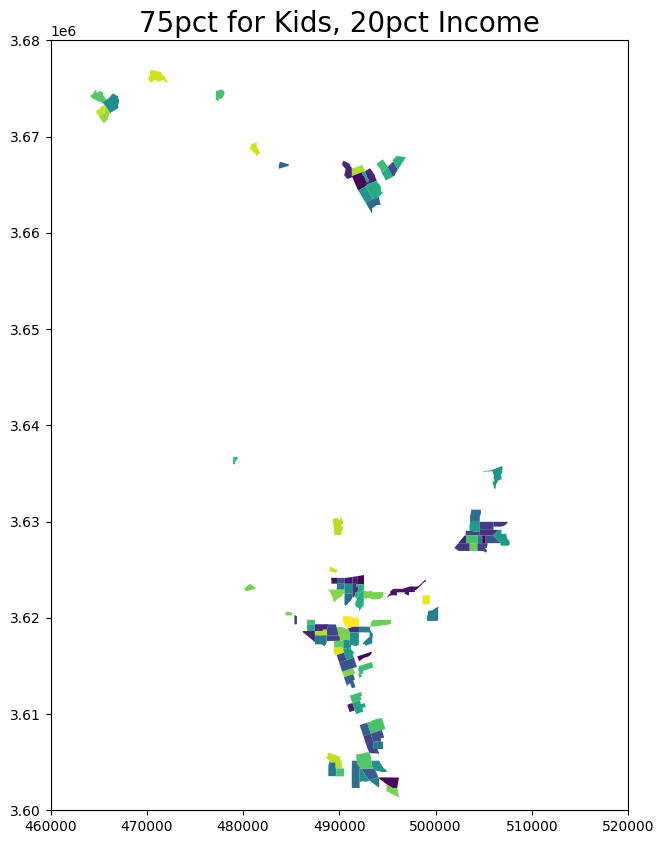

In [10]:
# Child Density for top 20% of income
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Set the x and y limits to the specified bounds
ax.set_xlim(460000, 520000)
ax.set_ylim(3600000, 3680000)

t = df[ (df.mi_pct <= .20) & ( df.cd_pct > .70)]

t.to_file(dd / "cd_mi_20.geojson", driver='GeoJSON')

t.plot(ax=ax, column='metric')
ax.set_title('75pct for Kids, 20pct Income', fontdict={'fontsize': 20, 'fontweight': 'medium'})

# Time Series 






In [11]:
import geopandas as gpd
from pathlib import Path
import requests
import zipfile
import io

import os
os.environ["REQUESTS_CA_BUNDLE"] = "/etc/ssl/cert.pem" 

# Define the URLs for 2020 and 2010 tract shapefiles
# They changed the tracts for 2020. 
urls = {
    "2020": "https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_06_tract.zip",
    "2010": "https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_06_tract10.zip"
}

# Define the directory to save the shapefiles
data_dir = Path("data/shapefiles")
data_dir.mkdir(parents=True, exist_ok=True)

# Download and extract shapefiles
shapefiles = {}
for year, url in urls.items():
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(data_dir / year)
    shapefiles[year] = gpd.read_file(data_dir / year)

# Access the 2020 and 2010 tract shapefiles
tract_2020 = shapefiles["2020"]
tract_2010 = shapefiles["2010"]

# Access the 2020 and 2010 tract shapefiles
tract_2020 = shapefiles["2020"]
tract_2010 = shapefiles["2010"]

tract_2010 = tract_2010[tract_2010.COUNTYFP10 == '073']
tract_2010 = tract_2010.rename(columns={'GEOID10':'geoid', 'ALAND': 'area'})
tract_2010['geoid'] = '14000US' + tract_2010['geoid']

tract_2020 = tract_2020[tract_2020.COUNTYFP == '073']
tract_2020 = tract_2020.rename(columns={'GEOID':'geoid', 'ALAND': 'area'})
tract_2020['geoid'] = '14000US' + tract_2020['geoid']

#tract_2010.head()

In [12]:
ter = gpd.GeoDataFrame(territories[['cid', 'geometry']].copy(), geometry='geometry')
ter10 = ter.sjoin(tract_2010[['geoid', 'geometry']].to_crs(ter.crs), predicate='intersects')
ter10 = ter10[['cid', 'geoid']].copy()


ter20 = ter.sjoin(tract_2020[['geoid', 'geometry']].to_crs(ter.crs), predicate='intersects')
ter20 = ter20[['cid', 'geoid']].copy()

In [13]:
tc_geo = ter_chld.geoid.unique()

In [14]:
from census import Census 
from us import states
import pandas as pd
from functools import reduce

api_key = "8a695c2cf16a80e406501af3c21a7492c85844a8"
col1 = "B09001_007E" # 9 to 11
col2 = "B09001_008E" # 12 to 14
 # B09001_009E # 15 to 17


def get_census_year(year):

    c = Census(api_key, year=year)

    r = c.acs5.get(('GEO_ID', col1, col2),  {'for': 'tract: *', 'in': 'state:06 county:073'})
    df = pd.DataFrame(r)
    df.rename(columns={ col1:(year,'y9'), col2:(year,'y12'), 'GEO_ID':('geoid','')}, inplace=True)
    df[('geoid','')] = df[('geoid','')].str.replace('1400000US', '14000US', regex=False)
    df =  df[[('geoid',''), (year, 'y9'), (year, 'y12')]].copy()
    df.columns = pd.MultiIndex.from_tuples(df.columns)
    return df

if not os.path.exists(dd / "census10_timeseries.pkl"):

    frames10 = [ get_census_year(year) for year in range(2010, 2020)]
    frames20 = [ get_census_year(year) for year in range(2020, 2024)]


    census10 = frames10[0]
    for df in frames10[1:]:
        census10 = pd.merge(census10, df, on=[('geoid','')], how='outer')

    census20 = frames20[0]
    for df in frames20[1:]:
        census20 = pd.merge(census20, df, on=[('geoid','')], how='outer')

    # Save census10 and census20 separately
    census10.to_pickle(dd / "census10_timeseries.pkl")
    census20.to_pickle(dd / "census20_timeseries.pkl")

else:
    census10 = pd.read_pickle(dd / "census10_timeseries.pkl")
    census20 = pd.read_pickle(dd / "census20_timeseries.pkl")



In [15]:
def select_flt(df, y_value):
    """
    Selects the 'geoid' column and all columns where the second level is y_value,
    then flattens the columns so they are single-level: 'geoid', 2010, 2011, ...
    
    Args:
        df (pd.DataFrame): Input dataframe with a MultiIndex columns
        y_value (str): The value to select ('y9' or 'y12')
    
    Returns:
        pd.DataFrame: DataFrame with 'geoid' and year columns, flat columns
    """
    # Select the columns
    selected_cols = [col for col in df.columns if col == ('geoid', '') or col[1] == y_value]
    # Select the data
    out = df.loc[:, selected_cols].copy()
    # Flatten columns: 'geoid' stays 'geoid', rest become just the year
    out.columns = [
        'geoid' if col == ('geoid', '') else col[0]
        for col in out.columns
    ]
    return out



select_flt(census10, 'y12').head()

,geoid,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,14000US06073000100,97.0,76.0,65.0,47.0,81.0,58.0,45.0,55.0,70.0,37.0
1,14000US06073000201,24.0,26.0,15.0,23.0,33.0,42.0,45.0,61.0,49.0,40.0
2,14000US06073000202,26.0,12.0,40.0,28.0,45.0,78.0,91.0,106.0,120.0,169.0
3,14000US06073000300,12.0,0.0,0.0,0.0,18.0,28.0,16.0,18.0,18.0,0.0
4,14000US06073000400,0.0,0.0,0.0,0.0,0.0,0.0,28.0,41.0,38.0,43.0


In [16]:


t10 = ter10.merge(select_flt(census10, 'y12'), on='geoid', how='left').drop(columns=['geoid']).groupby('cid').sum().sort_index()
t20 = ter20.merge(select_flt(census20, 'y12'), on='geoid', how='left').drop(columns=['geoid']).groupby('cid').sum().sort_index()

tc_ts_12 = pd.concat([t10, t20], axis=1)

tc_ts_12

t10 = ter10.merge(select_flt(census10, 'y9'), on='geoid', how='left').drop(columns=['geoid']).groupby('cid').sum().sort_index()
t20 = ter20.merge(select_flt(census20, 'y9'), on='geoid', how='left').drop(columns=['geoid']).groupby('cid').sum().sort_index()

tc_ts_9 = pd.concat([t10, t20], axis=1)


# Sum the 9 and 12 dataframes by matching row index (cid) and year (columns)
tc_ts_912 = tc_ts_9.add(tc_ts_12, fill_value=0)


tc_ts_912

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
cid,,,,,,,,,,,,,,
Code Ninjas-3,15886.0,16389.0,16058.0,16444.0,17285.0,17464.0,18642.0,18853.0,19025.0,19271.0,19631.0,19754.0,20169.0,19195.0
Code Ninjas-4,21985.0,21503.0,21632.0,21272.0,21728.0,21415.0,22499.0,23180.0,24359.0,24049.0,24063.0,22976.0,21606.0,21738.0
Code Ninjas-5,21724.0,21420.0,21025.0,21322.0,21266.0,21269.0,21707.0,21767.0,22034.0,21715.0,20478.0,19907.0,18707.0,18619.0
Code Ninjas-6,26915.0,26413.0,25864.0,25896.0,25928.0,25809.0,25788.0,25964.0,25788.0,25924.0,24547.0,25350.0,26100.0,26031.0
Ember Coding-7,28434.0,28463.0,28281.0,28926.0,29130.0,28825.0,29654.0,30516.0,31107.0,31018.0,29760.0,29148.0,27205.0,27572.0
The Coder School-0,28434.0,28463.0,28281.0,28926.0,29130.0,28825.0,29654.0,30516.0,31107.0,31018.0,29760.0,29148.0,27205.0,27572.0
The Coder School-1,15548.0,15980.0,15660.0,16080.0,16817.0,17086.0,18242.0,18488.0,18657.0,18915.0,18345.0,18491.0,18989.0,17882.0
The Coder School-2,7497.0,7610.0,7589.0,7227.0,7735.0,7755.0,7683.0,8463.0,8516.0,8522.0,9026.0,9021.0,8142.0,8010.0
The League-8,12350.0,12362.0,12435.0,12854.0,13111.0,13064.0,13560.0,13567.0,13232.0,13937.0,13207.0,12625.0,12322.0,12718.0


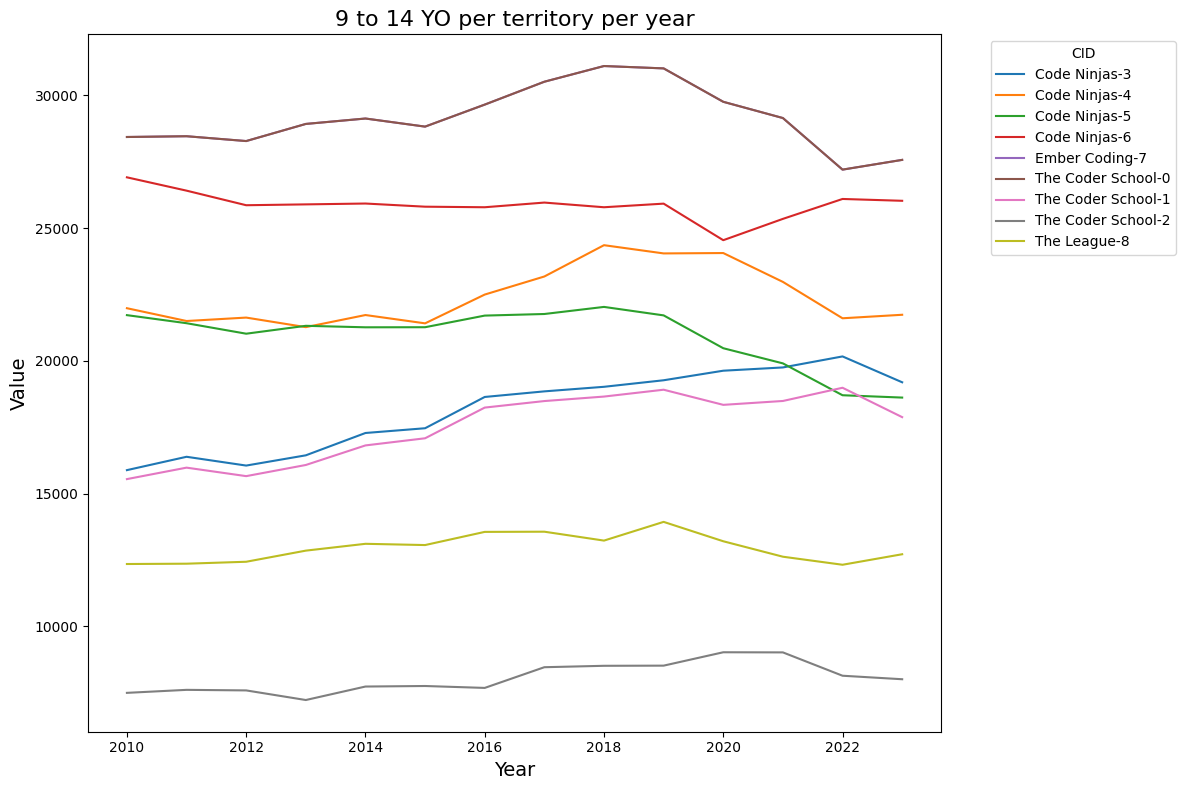

In [17]:


t = tc_ts_912

t = t.groupby('cid').sum()
 
# Plotting the multi-line chart
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each row as a line
for index, row in t.iterrows():
    ax.plot(range(2010, 2024), row.values, label=index)

# Add labels, title, and legend
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Value', fontsize=14)
ax.set_title('9 to 14 YO per territory per year', fontsize=16)
ax.legend(title='CID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
 

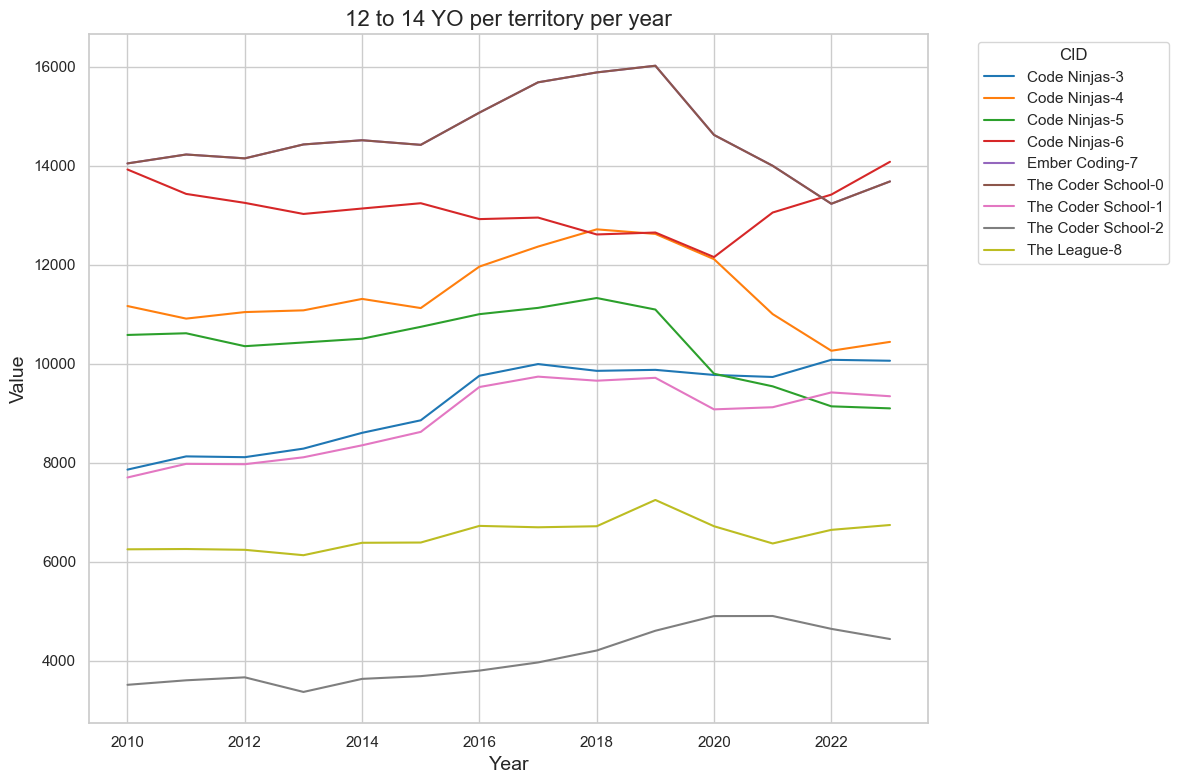

In [18]:
import seaborn as sns
sns.set_theme(style="whitegrid")
tc_ts_transposed = tc_ts_12.T.reset_index().rename(columns={"index": "Year"})
tc_ts_transposed = pd.melt(tc_ts_transposed, id_vars=["Year"], var_name="CID", value_name="Value")

plt.figure(figsize=(12, 8))
sns.lineplot(data=tc_ts_transposed, x="Year", y="Value", hue="CID", palette="tab10")
plt.title("12 to 14 YO per territory per year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(title="CID", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


<Axes: >

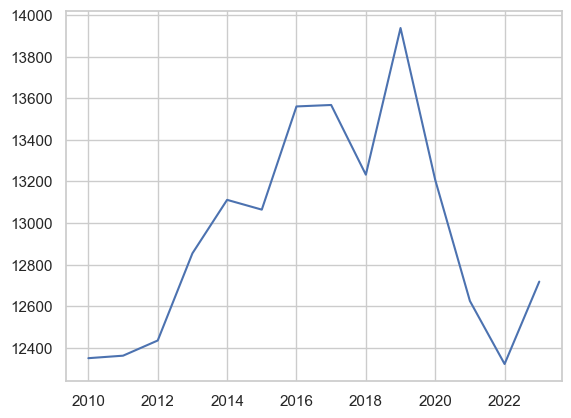

In [22]:
t = tc_ts_912

t.loc['The League-8'].plot()